<a href="https://colab.research.google.com/github/sahilsait/synthetic-EHR-data-generation/blob/main/CS271_final_project_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/datasets/ehr_clean.csv')
df.head()

,MARITAL,RACE,ETHNICITY,GENDER,age,DESCRIPTION,num_encounters,last_encounter_type,body_mass_index,heart_rate,systolic_blood_pressure
0,M,white,hispanic,M,35,Chronic sinusitis (disorder),6,ambulatory,23.1,62.0,130.0
1,M,white,hispanic,M,35,Viral sinusitis (disorder),6,ambulatory,23.1,62.0,130.0
2,M,white,hispanic,M,35,Viral sinusitis (disorder),6,ambulatory,23.1,62.0,130.0
3,M,white,nonhispanic,M,41,Acute bronchitis (disorder),6,wellness,23.5,66.0,103.0
4,M,white,nonhispanic,M,32,Acute bronchitis (disorder),12,outpatient,27.8,64.0,106.0


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
from torch.utils.data import TensorDataset, DataLoader

categorical_cols = ["RACE", "ETHNICITY", "MARITAL", "GENDER", "last_encounter_type", "DESCRIPTION"]
numerical_cols   = ["age", "num_encounters", "body_mass_index", "heart_rate", "systolic_blood_pressure"]


# Build the ColumnTransformer
preprocessor = ColumnTransformer([
    # scale all numerics to mean=0, std=1
    ('num', StandardScaler(), numerical_cols),
    # one-hot encode each category;
    ('cat', OneHotEncoder(), categorical_cols),
])

# Fit & transform
X = preprocessor.fit_transform(df)

# (n_samples, input_dim)
print("shape of X:", X.shape)

# Turn into PyTorch DataLoader
tensor   = torch.tensor(X.toarray(), dtype=torch.float32)
dataset  = TensorDataset(tensor)
loader   = DataLoader(dataset, batch_size=64, shuffle=True)

shape of X: (8322, 152)


In [ ]:
from scipy.sparse import save_npz, load_npz
import joblib

# Save after fitting
joblib.dump(preprocessor, '/content/drive/MyDrive/datasets/preprocessor.pkl')

# Save sparse matrix
save_npz('/content/drive/MyDrive/datasets/X.npz', X)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_val = train_test_split(tensor, test_size=0.2, random_state=42)
train_ds = TensorDataset(X_train)
val_ds   = TensorDataset(X_val)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False)

In [ ]:
X.shape

(8322, 152)

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import logit  # if you used sigmoid on numerics

# Extract the fitted sub-transformers:
num_scaler = preprocessor.named_transformers_['num']
ohe        = preprocessor.named_transformers_['cat']
# How many input dims each produced?
n_num      = len(numerical_cols)
cat_sizes  = [len(cats) for cats in ohe.categories_]
# Cumulative splits for slicing
splits     = np.cumsum(cat_sizes)[:-1]

def array_to_df(synth_arr):
    """
    synth_arr: (n_samples, 152) array from VAE / WGAN-GP / Diffusion
    returns: DataFrame of shape (n_samples, 11) with original features
    """
    # 1) Numeric block
    num_block = synth_arr[:, :n_num]
    num_orig  = num_scaler.inverse_transform(num_block)

    # 2) Categorical block
    cat_block = synth_arr[:, n_num:]
    # Split into each feature’s one-hot subarray
    cat_splits = np.split(cat_block, splits, axis=1)
    decoded = {}
    for i, cats in enumerate(ohe.categories_):
        # pick the most likely category
        idx = cat_splits[i].argmax(axis=1)
        decoded[categorical_cols[i]] = np.array(cats)[idx]

    # Build DataFrame
    df_s = pd.DataFrame(num_orig, columns=numerical_cols)
    for col in categorical_cols:
        df_s[col] = decoded[col]
    return df_s

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, n_cont, latent_dim, hidden_dim=128):
        super().__init__()
        self.n_cont = n_cont
        self.n_cat  = input_dim - n_cont

        # Encoder
        self.fc1       = nn.Linear(input_dim, hidden_dim)
        self.fc_mu     = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Shared decoder body
        self.fc2       = nn.Linear(latent_dim, hidden_dim)

        # Continuous head (Gaussian)
        self.fc_cont_mu     = nn.Linear(hidden_dim, n_cont)
        self.fc_cont_logvar = nn.Linear(hidden_dim, n_cont)

        # Categorical head (Bernoulli per one‐hot slot)
        self.fc_cat_logits  = nn.Linear(hidden_dim, self.n_cat)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + std * torch.randn_like(std)

    def decode(self, z):
        h = F.relu(self.fc2(z))

        # Continuous reconstruction parameters
        mu_cont     = self.fc_cont_mu(h)
        logvar_cont = self.fc_cont_logvar(h)

        # Categorical logits
        logits_cat  = self.fc_cat_logits(h)

        return mu_cont, logvar_cont, logits_cat

    def forward(self, x):
        # encode
        mu_z, logvar_z = self.encode(x)
        z              = self.reparameterize(mu_z, logvar_z)
        # decode
        mu_cont, logvar_cont, logits_cat = self.decode(z)
        return mu_cont, logvar_cont, logits_cat, mu_z, logvar_z

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch import optim

# Hyperparams
input_dim  = X.shape[1]       # 152
n_cont     = len(numerical_cols)  # 5
latent_dim = 16
lr         = 1e-3
epochs     = 50
patience   = 5               # stop if no improvement for 5 epochs
ckpt_path  = "/content/drive/MyDrive/models/vae_best.pth"  # overwrite this file whenever we improve

# Model + Optimizer
vae       = VAE(input_dim, n_cont, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

best_val = float('inf')
wait     = 0

for epoch in range(1, epochs + 1):
    # Training
    vae.train()
    train_loss = 0.0
    for (x_batch,) in train_loader:
        x = x_batch.to(device)

        mu_cont, logvar_cont, logits_cat, mu_z, logvar_z = vae(x)

        # split, recon + KL
        x_cont = x[:, :n_cont]; x_cat = x[:, n_cont:]
        recon_cont = 0.5 * torch.sum(logvar_cont + (x_cont - mu_cont).pow(2) / logvar_cont.exp())
        recon_cat  = F.binary_cross_entropy_with_logits(logits_cat, x_cat, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())

        loss = recon_cont + recon_cat + kl
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss += loss.item()

    avg_train = train_loss / len(train_loader.dataset)

    # Validation
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (x_batch,) in val_loader:
            x = x_batch.to(device)

            mu_cont, logvar_cont, logits_cat, mu_z, logvar_z = vae(x)
            x_cont = x[:, :n_cont]; x_cat = x[:, n_cont:]
            recon_cont = 0.5 * torch.sum(logvar_cont + (x_cont - mu_cont).pow(2) / logvar_cont.exp())
            recon_cat  = F.binary_cross_entropy_with_logits(logits_cat, x_cat, reduction='sum')
            kl = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())

            val_loss += (recon_cont + recon_cat + kl).item()

    avg_val = val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch:02d} — Train ELBO: {avg_train:.4f} ; Val ELBO: {avg_val:.4f}")

    # Early-stopping & Checkpoint
    if avg_val < best_val:
        best_val = avg_val
        wait = 0
        torch.save(vae.state_dict(), ckpt_path)
        print(f"  ▶ New best val ELBO: {best_val:.4f} (saved to {ckpt_path})")
    else:
        wait += 1
        print(f"  ◼ No improvement for {wait}/{patience} epochs")
        if wait >= patience:
            print(f"Stopping early at epoch {epoch}")
            break


Epoch 01 — Train ELBO: 37.6143 ; Val ELBO: 18.5063
  ▶ New best val ELBO: 18.5063 (saved to /content/drive/MyDrive/models/vae_best.pth)
Epoch 02 — Train ELBO: 17.2880 ; Val ELBO: 16.1091
  ▶ New best val ELBO: 16.1091 (saved to /content/drive/MyDrive/models/vae_best.pth)
Epoch 03 — Train ELBO: 15.6627 ; Val ELBO: 14.7052
  ▶ New best val ELBO: 14.7052 (saved to /content/drive/MyDrive/models/vae_best.pth)
Epoch 04 — Train ELBO: 14.3716 ; Val ELBO: 13.6345
  ▶ New best val ELBO: 13.6345 (saved to /content/drive/MyDrive/models/vae_best.pth)
Epoch 05 — Train ELBO: 13.2794 ; Val ELBO: 12.6333
  ▶ New best val ELBO: 12.6333 (saved to /content/drive/MyDrive/models/vae_best.pth)
Epoch 06 — Train ELBO: 12.5740 ; Val ELBO: 12.2025
  ▶ New best val ELBO: 12.2025 (saved to /content/drive/MyDrive/models/vae_best.pth)
Epoch 07 — Train ELBO: 12.1620 ; Val ELBO: 11.8765
  ▶ New best val ELBO: 11.8765 (saved to /content/drive/MyDrive/models/vae_best.pth)
Epoch 08 — Train ELBO: 11.9241 ; Val ELBO: 11.88

In [ ]:
vae.eval()

def gen_vae(n, sample_cont=False):
    z = torch.randn(n, latent_dim, device=device)
    with torch.no_grad():
        mu_cont, logvar_cont, logits_cat = vae.decode(z)

        # Continuous features: either use the mean or sample from N(mu,σ²)
        if sample_cont:
            std = torch.exp(0.5 * logvar_cont)
            eps = torch.randn_like(std)
            cont_dec = mu_cont + eps * std
        else:
            cont_dec = mu_cont

        # 2) Categorical features: probabilities via sigmoid
        cat_dec = torch.sigmoid(logits_cat)

        # 3) Concatenate back to full feature vector
        x_dec = torch.cat([cont_dec, cat_dec], dim=1)

    return x_dec.cpu().numpy()

s_vae  = gen_vae(X.shape[0])
df_vae  = array_to_df(s_vae)
#df_wgan  = array_to_df(s_wgan)
#df_diff = array_to_df(s_diff)

#print(df_vae.shape, df_wgan.shape, df_diff.shape)

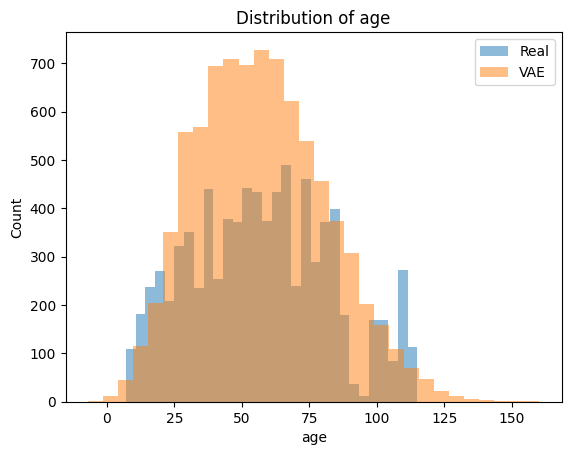

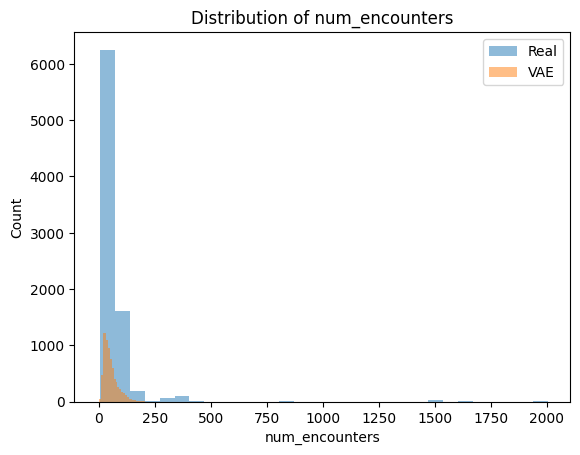

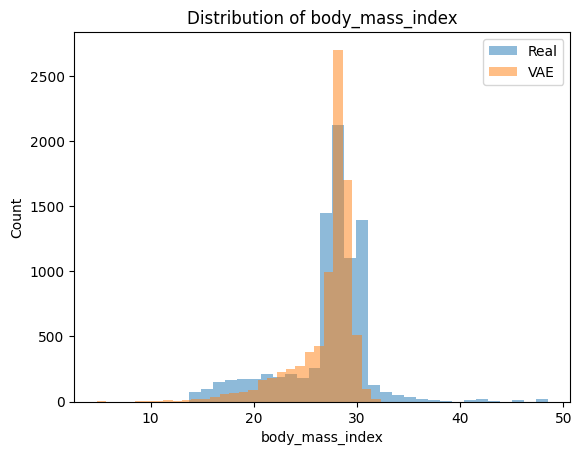

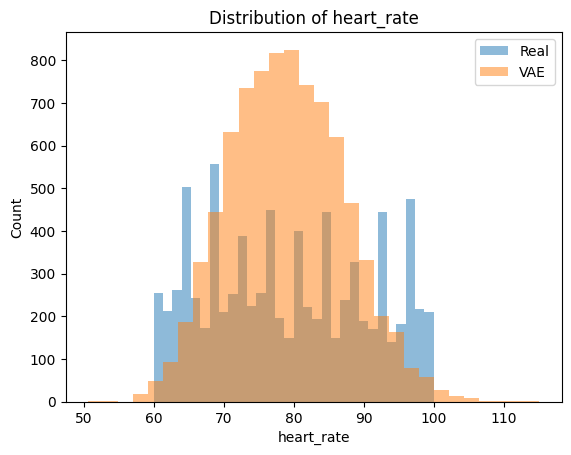

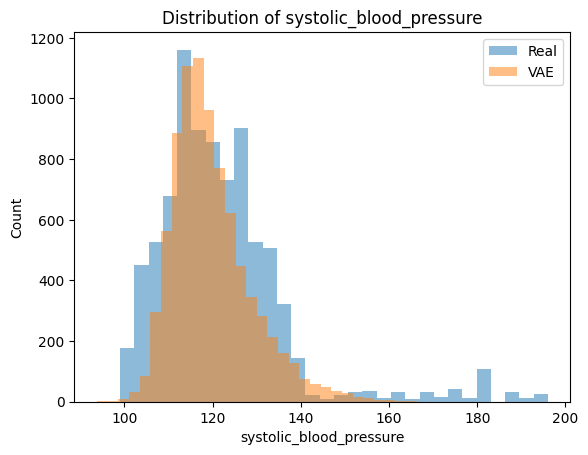

In [ ]:
import matplotlib.pyplot as plt

for col in numerical_cols:
    plt.figure()
    plt.hist(df[col], bins=30, alpha=0.5, label='Real')
    plt.hist(df_vae[col],  bins=30, alpha=0.5, label='VAE')
    plt.legend()
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

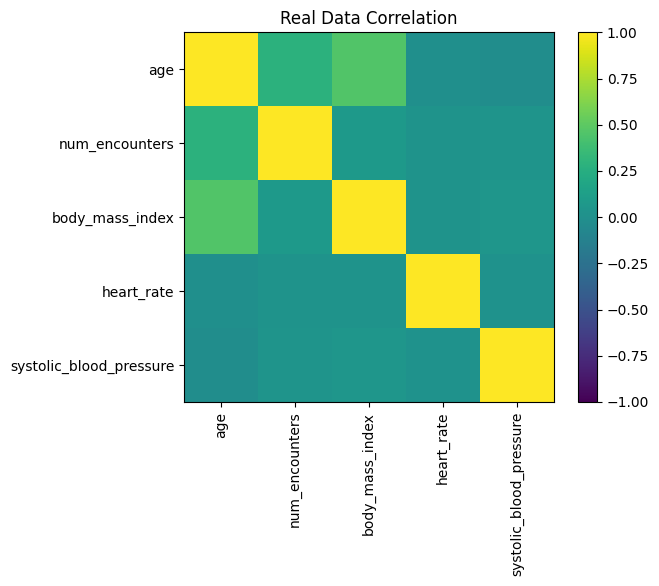

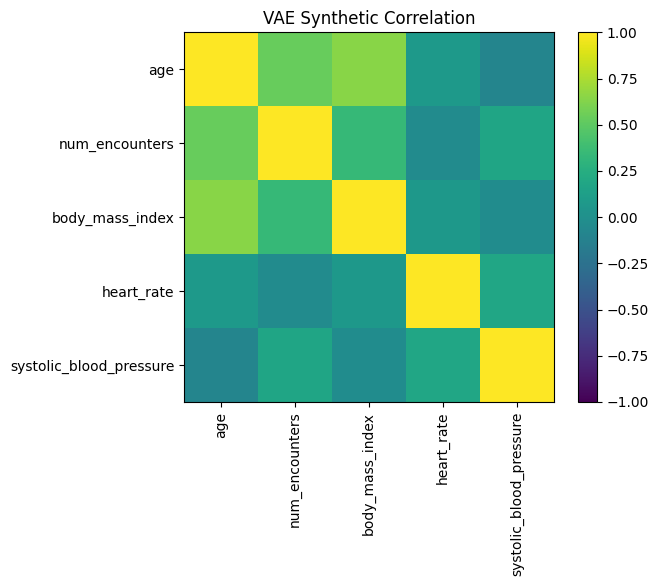

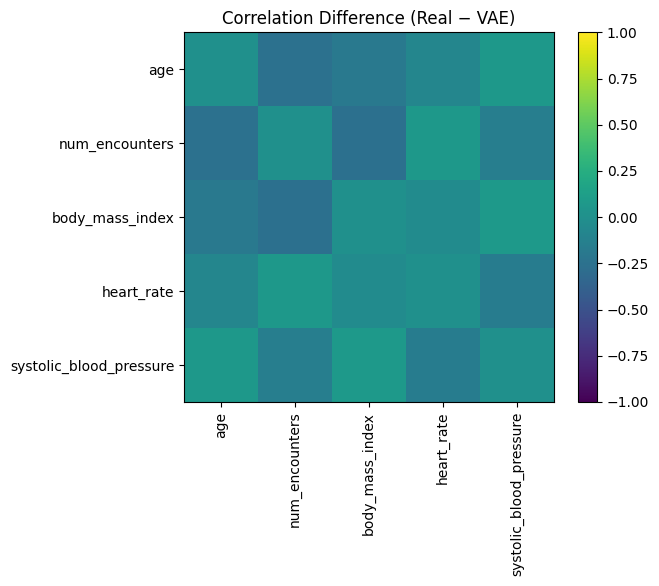

In [ ]:
import matplotlib.pyplot as plt

# compute
corr_real = df[numerical_cols].corr()
corr_vae  = df_vae[numerical_cols].corr()
corr_diff = corr_real - corr_vae

# real
plt.figure()
plt.imshow(corr_real, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('Real Data Correlation')
plt.show()

# VAE
plt.figure()
plt.imshow(corr_vae, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('VAE Synthetic Correlation')
plt.show()

# difference
plt.figure()
plt.imshow(corr_diff, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('Correlation Difference (Real − VAE)')
plt.show()


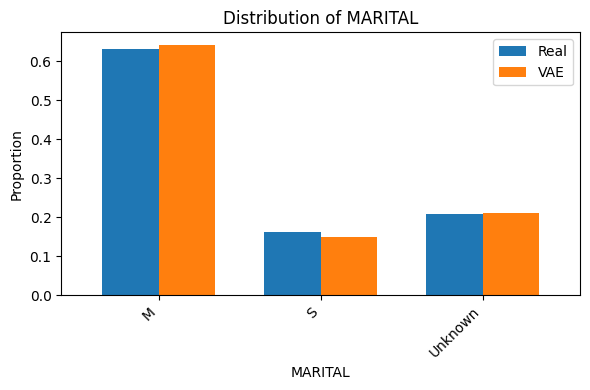

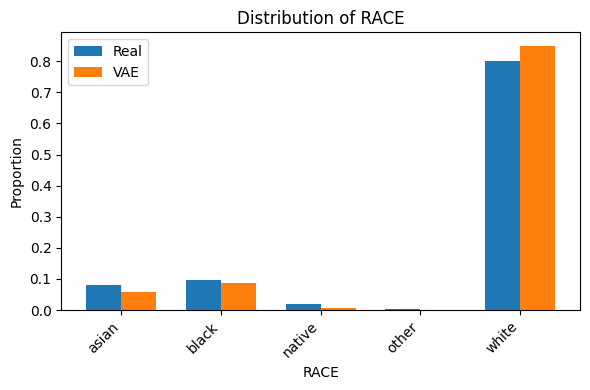

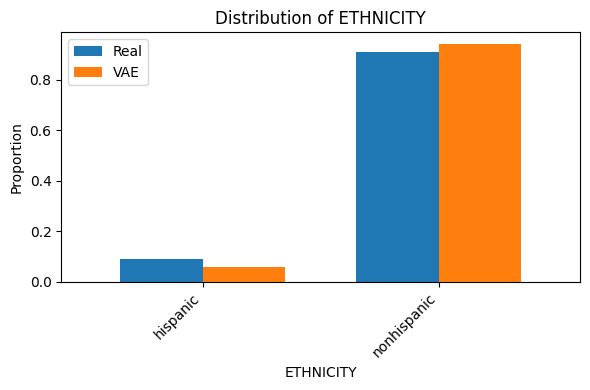

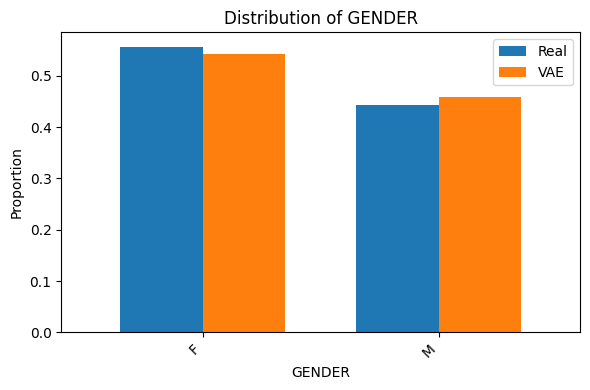

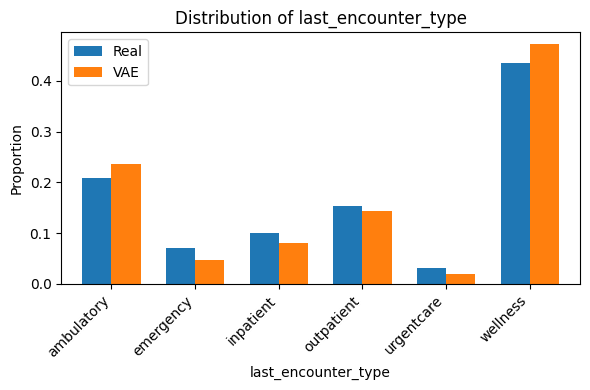

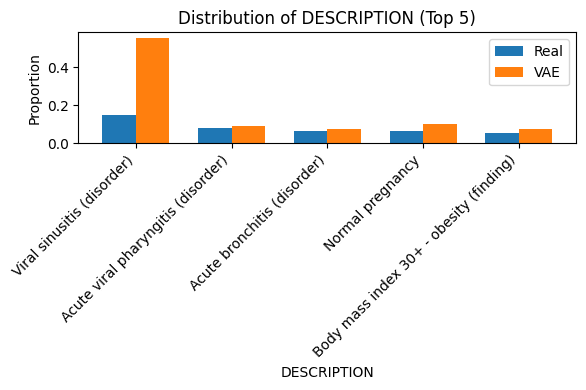

In [ ]:
import matplotlib.pyplot as plt

cat_cols = ['MARITAL', 'RACE', 'ETHNICITY', 'GENDER', 'last_encounter_type', 'DESCRIPTION']

for col in cat_cols:
    if col == 'DESCRIPTION':
        # Get top 5 most frequent categories from real data
        top5 = df[col].value_counts(normalize=True).nlargest(5)
        # Align VAE counts to the same top 5 categories
        vae_counts = df_vae[col].value_counts(normalize=True).reindex(top5.index, fill_value=0)

        df_counts = pd.DataFrame({
            'Real': top5,
            'VAE':  vae_counts
        })
    else:
        real_counts = df[col].value_counts(normalize=True).sort_index()
        vae_counts = df_vae[col].value_counts(normalize=True).reindex(real_counts.index, fill_value=0)

        df_counts = pd.DataFrame({
            'Real': real_counts,
            'VAE':  vae_counts
        })

    # Plot
    ax = df_counts.plot(kind='bar', width=0.7, figsize=(6,4))
    if col == 'DESCRIPTION':
      ax.set_title(f'Distribution of {col} (Top 5)')
    else:
      ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Config
n_cat      = input_dim - n_cont   # 147
latent_dim = 32
hidden_dim = 128
lr         = 1e-3
lambda_gp  = 10
n_critic   = 5
epochs     = 50

# Generator with separate heads
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.cont_head = nn.Linear(hidden_dim, n_cont)
        self.cat_head  = nn.Linear(hidden_dim, n_cat)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        cont = self.cont_head(h)            # real-valued output
        cat  = torch.sigmoid(self.cat_head(h))  # [0,1] for one-hot
        return torch.cat([cont, cat], dim=1)

# Critic (WGAN-GP)
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

# Gradient Penalty
def gradient_penalty(critic, real, fake):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, device=device).expand_as(real)
    interp = (epsilon * real + (1 - epsilon) * fake).requires_grad_(True)
    prob = critic(interp)
    grads = torch.autograd.grad(
        outputs=prob, inputs=interp,
        grad_outputs=torch.ones_like(prob),
        create_graph=True
    )[0]
    grads = grads.view(batch_size, -1)
    return ((grads.norm(2, dim=1) - 1) ** 2).mean()


# Instantiate
G    = Generator().to(device)
C    = Critic().to(device)
optG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optC = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.9))

for epoch in range(1, epochs+1):
    # Training on train_loader
    for (real_batch,) in train_loader:
        real = real_batch.to(device)
        batch_size = real.size(0)

        # Critic updates
        for _ in range(n_critic):
            z    = torch.randn(batch_size, latent_dim, device=device)
            fake = G(z).detach()

            loss_real = -C(real).mean()
            loss_fake =  C(fake).mean()
            gp        =  gradient_penalty(C, real, fake)
            lossC     =  loss_real + loss_fake + lambda_gp * gp

            optC.zero_grad()
            lossC.backward()
            optC.step()

        # Generator update
        z     = torch.randn(batch_size, latent_dim, device=device)
        fake  = G(z)
        lossG = -C(fake).mean()

        optG.zero_grad()
        lossG.backward()
        optG.step()

    # Validation on val_loader
    C.eval(); G.eval()
    valC_loss = 0.0
    valG_loss = 0.0
    with torch.no_grad():
        for (real_batch,) in val_loader:
            real = real_batch.to(device)
            bsz  = real.size(0)

            # Critic on real vs fake
            loss_real = -C(real).mean()
            z         = torch.randn(bsz, latent_dim, device=device)
            fake      = G(z)
            loss_fake =  C(fake).mean()
            valC_loss += (loss_real + loss_fake).item()

            # Generator “fooling” loss
            valG_loss += (-C(fake).mean()).item()

    n_val = len(val_loader)
    print(f"[Epoch {epoch:02d}]  "
          f"Train C: {lossC.item():.4f}, G: {lossG.item():.4f}  |  "
          f"Val C: {valC_loss/n_val:.4f}, G: {valG_loss/n_val:.4f}")

    C.train(); G.train()

# Save final generator
torch.save(G.state_dict(),
           '/content/drive/MyDrive/models/generator_weights.pth')

[Epoch 01]  Train C: -1.7780, G: 0.4320  |  Val C: -1.1521, G: 0.3528
[Epoch 02]  Train C: -0.3005, G: -0.3459  |  Val C: -0.9233, G: -0.8401
[Epoch 03]  Train C: -1.2811, G: -0.2547  |  Val C: -0.8600, G: -0.2904
[Epoch 04]  Train C: -1.8206, G: -1.5210  |  Val C: -0.5124, G: -1.1236
[Epoch 05]  Train C: -1.9978, G: 0.1082  |  Val C: -0.8199, G: -0.1317
[Epoch 06]  Train C: -1.6097, G: 0.2592  |  Val C: -0.4999, G: -0.3607
[Epoch 07]  Train C: -1.2596, G: 0.2531  |  Val C: -0.7377, G: 0.0260
[Epoch 08]  Train C: -1.8280, G: -0.0183  |  Val C: -0.6155, G: -0.0888
[Epoch 09]  Train C: -1.0708, G: -0.4427  |  Val C: -0.5067, G: -0.0310
[Epoch 10]  Train C: -1.9886, G: -0.1563  |  Val C: -0.2287, G: -0.1155
[Epoch 11]  Train C: -1.3304, G: -0.0323  |  Val C: -0.6034, G: 0.0840
[Epoch 12]  Train C: -2.1723, G: 0.3810  |  Val C: -0.3651, G: -0.1918
[Epoch 13]  Train C: -2.4999, G: 0.3913  |  Val C: -0.5046, G: 0.1517
[Epoch 14]  Train C: -1.6486, G: 0.1966  |  Val C: -0.3832, G: 0.2372
[Epo

In [ ]:
G.eval()
#df_diff = array_to_df(s_diff)

def gen_wgan(n):
    z = torch.randn(n, latent_dim, device=device)
    with torch.no_grad():
        # G already concatenates continuous + categorical heads
        return G(z).cpu().numpy()

s_wgan = gen_wgan(X.shape[0])
df_wgan  = array_to_df(s_wgan)

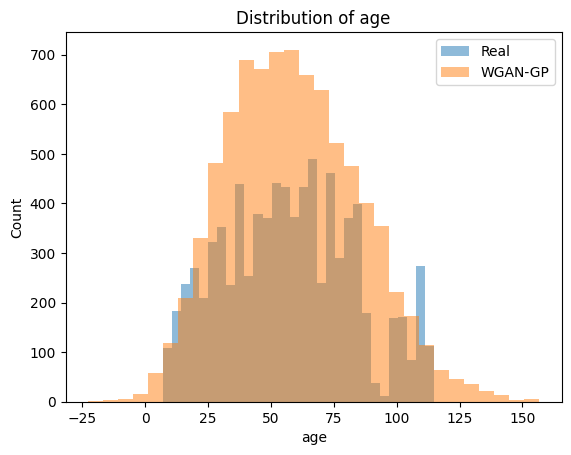

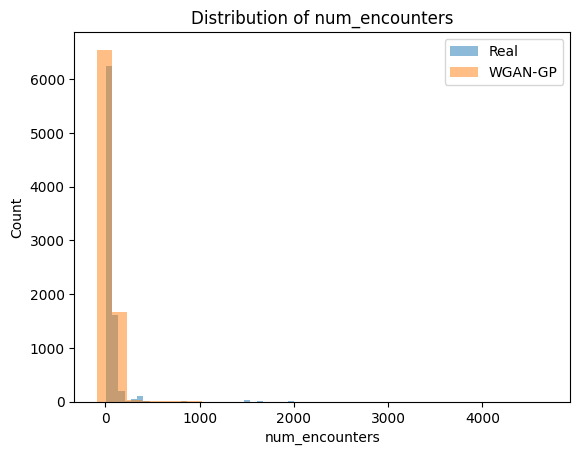

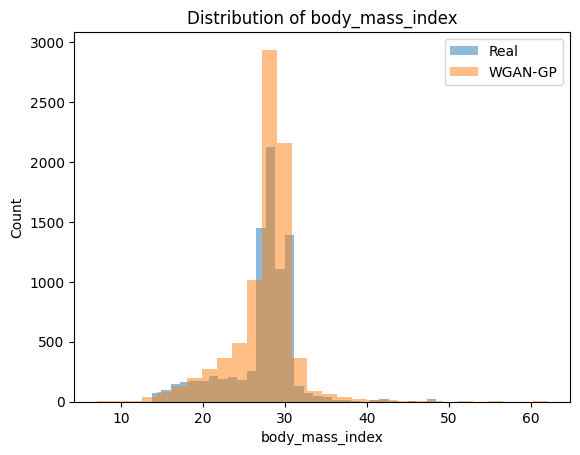

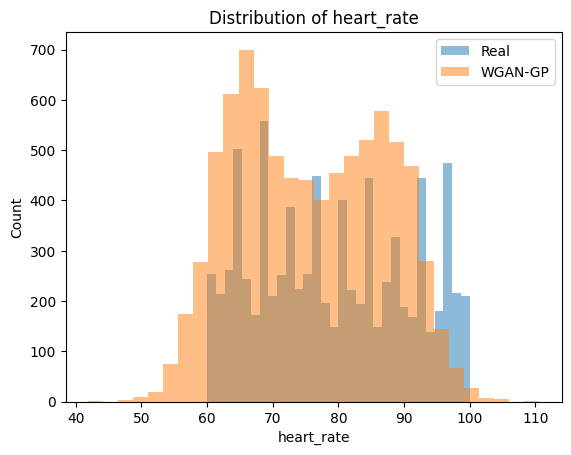

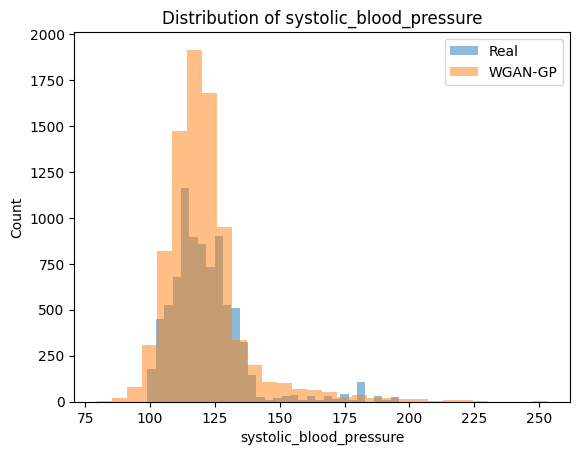

In [ ]:
import matplotlib.pyplot as plt

for col in numerical_cols:
    plt.figure()
    plt.hist(df[col], bins=30, alpha=0.5, label='Real')
    plt.hist(df_wgan[col],  bins=30, alpha=0.5, label='WGAN-GP')
    plt.legend()
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

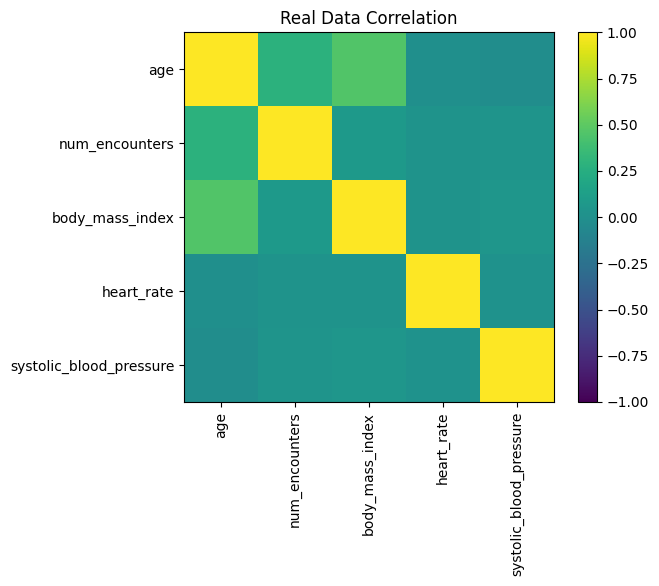

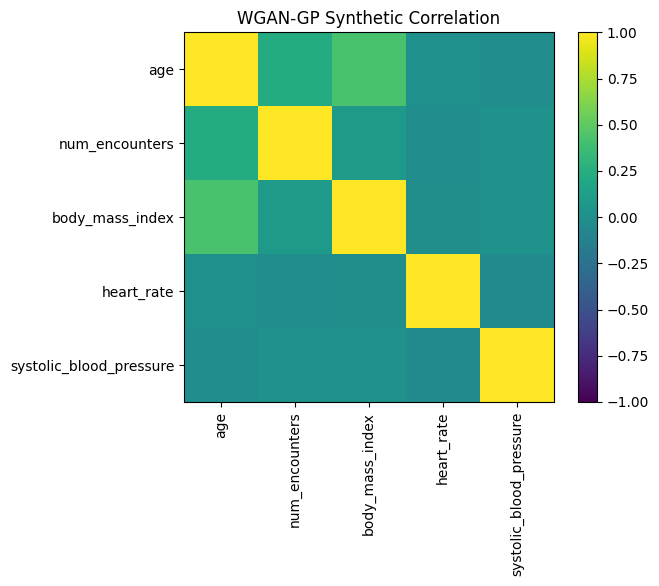

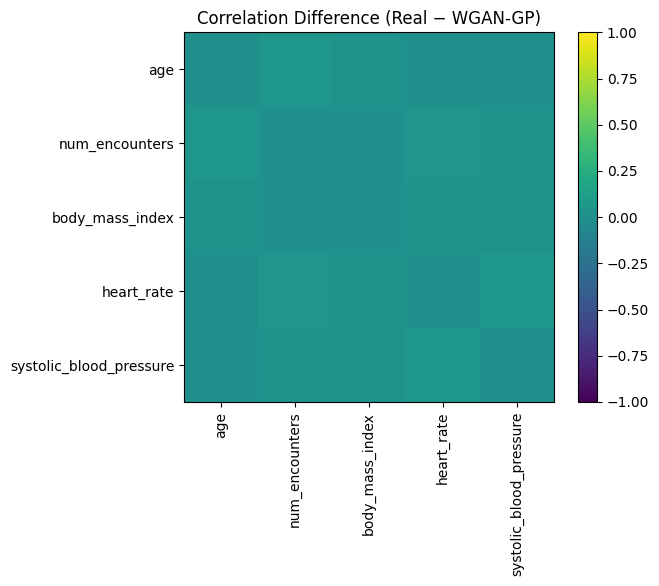

In [ ]:
import matplotlib.pyplot as plt

# compute
corr_real = df[numerical_cols].corr()
corr_gan  = df_wgan[numerical_cols].corr()
corr_diff = corr_real - corr_gan

# real
plt.figure()
plt.imshow(corr_real, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('Real Data Correlation')
plt.show()

# WGAN-GP
plt.figure()
plt.imshow(corr_gan, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('WGAN-GP Synthetic Correlation')
plt.show()

# difference
plt.figure()
plt.imshow(corr_diff, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('Correlation Difference (Real − WGAN-GP)')
plt.show()

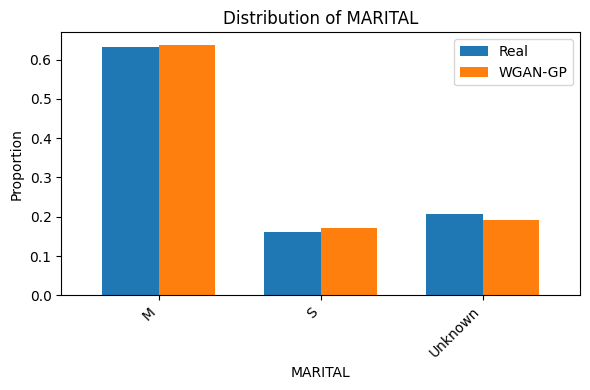

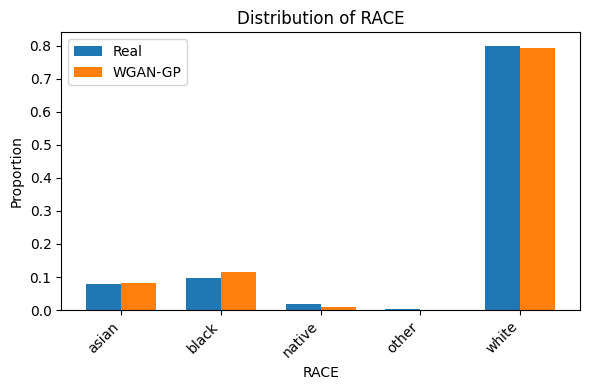

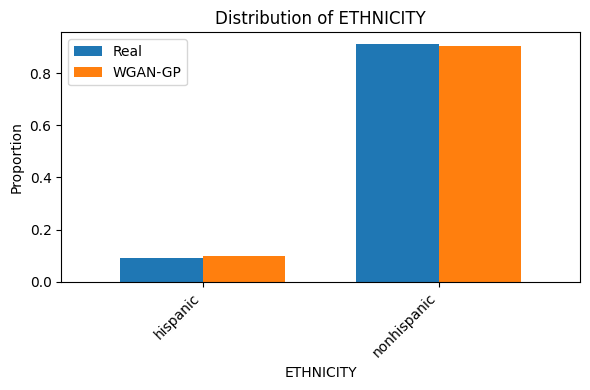

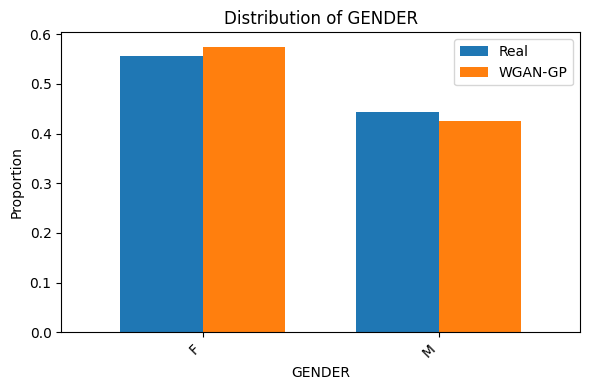

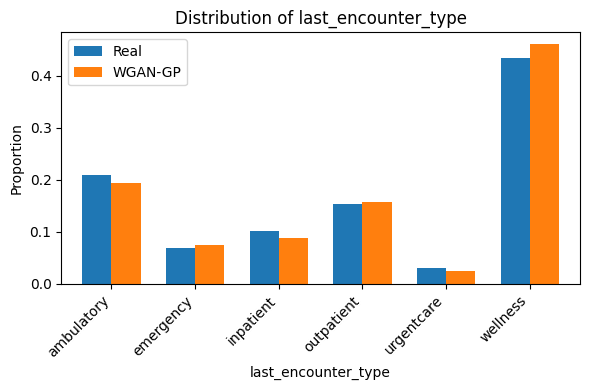

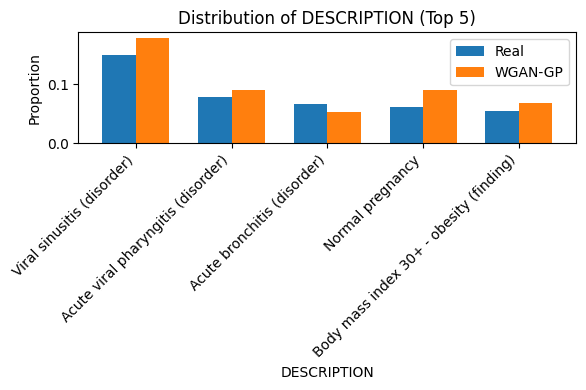

In [ ]:
import matplotlib.pyplot as plt

# List of your categorical columns
cat_cols = ['MARITAL','RACE','ETHNICITY','GENDER','last_encounter_type','DESCRIPTION']

for col in cat_cols:
    if col == 'DESCRIPTION':
        # Get top 5 most frequent categories from real data
        top5 = df[col].value_counts(normalize=True).nlargest(5)
        wgan_counts = df_wgan[col].value_counts(normalize=True).reindex(top5.index, fill_value=0)
        df_counts = pd.DataFrame({
            'Real': top5,
            'WGAN-GP':  wgan_counts
        })
    else:
      real_counts  = df[col].value_counts(normalize=True).sort_index()
      gan_counts   = df_wgan[col].value_counts(normalize=True).reindex(real_counts.index, fill_value=0)

      # Build a DataFrame so matplotlib can auto-align bars
      df_counts = pd.DataFrame({
          'Real': real_counts,
          'WGAN-GP':  gan_counts
      })

    # Plot grouped bar chart
    ax = df_counts.plot(kind='bar', width=0.7, figsize=(6,4))
    if col == 'DESCRIPTION':
        ax.set_title(f'Distribution of {col} (Top 5)')
    else:
        ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
class Diffusion(nn.Module):
    def __init__(self, input_dim, n_cont):
        super().__init__()
        self.n_cont = n_cont
        self.n_cat  = input_dim - n_cont

        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        # two heads:
        self.cont_head = nn.Linear(128, n_cont)       # real outputs
        self.cat_head  = nn.Linear(128, self.n_cat)   # logits for one-hots

    def forward(self, x_noisy):
        h = self.net(x_noisy)
        cont_out = self.cont_head(h)            # unrestricted real
        cat_logits = self.cat_head(h)           # to sigmoid for probs
        return cont_out, cat_logits


In [ ]:
# Config & Initialization
input_dim   = X.shape[1]                 # e.g. 152
n_cont      = len(numerical_cols)        # e.g. 5
epochs      = 50
noise_scale = 0.5
lr          = 1e-3
ckpt_path   = "/content/drive/MyDrive/models/diffusion_best.pth"

diff = Diffusion(input_dim=input_dim, n_cont=n_cont).to(device)
opt_d = optim.Adam(diff.parameters(), lr=lr)
mse   = nn.MSELoss(reduction='sum')
bce   = nn.BCEWithLogitsLoss(reduction='sum')

best_val_loss = float('inf')

# Training + Validation Loop
for ep in range(1, epochs+1):
    # Training
    diff.train()
    train_loss = 0.0
    for (x_batch,) in train_loader:
        x = x_batch.to(device)
        noise   = torch.randn_like(x) * noise_scale
        x_noisy = x + noise

        cont_pred, cat_logits = diff(x_noisy)
        x_cont = x[:, :n_cont]
        x_cat  = x[:, n_cont:]

        loss_cont = mse(cont_pred, x_cont)
        loss_cat  = bce(cat_logits, x_cat)
        loss      = loss_cont + loss_cat

        opt_d.zero_grad()
        loss.backward()
        opt_d.step()

        train_loss += loss.item()

    avg_train = train_loss / len(train_loader.dataset)

    # Validation
    diff.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (x_batch,) in val_loader:
            x = x_batch.to(device)
            noise   = torch.randn_like(x) * noise_scale
            x_noisy = x + noise

            cont_pred, cat_logits = diff(x_noisy)
            x_cont = x[:, :n_cont]
            x_cat  = x[:, n_cont:]

            val_loss += (mse(cont_pred, x_cont) + bce(cat_logits, x_cat)).item()

    avg_val = val_loss / len(val_loader.dataset)

    print(f"[Diffusion] Epoch {ep:02d} — Train Loss: {avg_train:.4f} ; Val Loss: {avg_val:.4f}")

    # Checkpoint best
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(diff.state_dict(), ckpt_path)
        print(f"  ▶ New best validation loss, saved to {ckpt_path}")

# After training
print(f"Training complete — best val loss = {best_val_loss:.4f}")

[Diffusion] Epoch 01 — Train Loss: 32.7654 ; Val Loss: 13.3007
  ▶ New best validation loss, saved to /content/drive/MyDrive/models/diffusion_best.pth
[Diffusion] Epoch 02 — Train Loss: 12.5535 ; Val Loss: 11.8540
  ▶ New best validation loss, saved to /content/drive/MyDrive/models/diffusion_best.pth
[Diffusion] Epoch 03 — Train Loss: 11.4169 ; Val Loss: 10.7855
  ▶ New best validation loss, saved to /content/drive/MyDrive/models/diffusion_best.pth
[Diffusion] Epoch 04 — Train Loss: 10.3946 ; Val Loss: 9.8700
  ▶ New best validation loss, saved to /content/drive/MyDrive/models/diffusion_best.pth
[Diffusion] Epoch 05 — Train Loss: 9.6142 ; Val Loss: 9.2895
  ▶ New best validation loss, saved to /content/drive/MyDrive/models/diffusion_best.pth
[Diffusion] Epoch 06 — Train Loss: 9.0483 ; Val Loss: 8.8376
  ▶ New best validation loss, saved to /content/drive/MyDrive/models/diffusion_best.pth
[Diffusion] Epoch 07 — Train Loss: 8.6212 ; Val Loss: 8.4594
  ▶ New best validation loss, saved to

In [ ]:
diff.eval()

def gen_diff(n):
    # Sample noise and denoise
    noise = torch.randn(n, input_dim, device=device) * noise_scale
    with torch.no_grad():
        cont_pred, cat_logits = diff(noise)

        # Continuous features come straight out
        cont_dec = cont_pred

        # Categorical probabilities via sigmoid
        cat_dec = torch.sigmoid(cat_logits)

        # Reassemble into full feature vector
        x_dec = torch.cat([cont_dec, cat_dec], dim=1)

    return x_dec.cpu().numpy()


# synthesize
s_diff = gen_diff(X.shape[0])
df_diff  = array_to_df(s_diff)

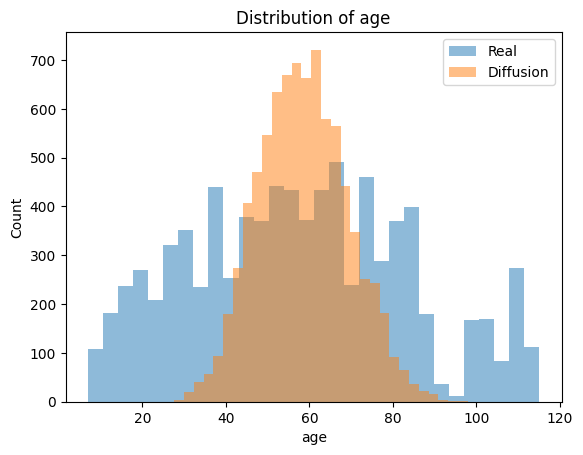

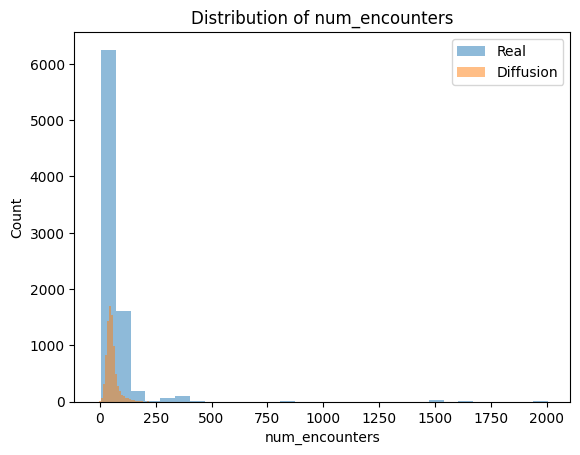

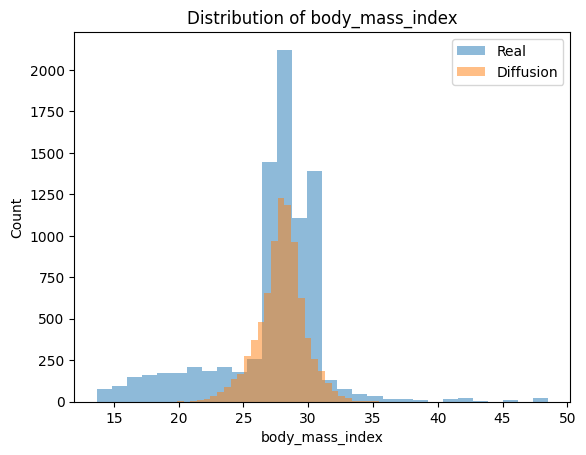

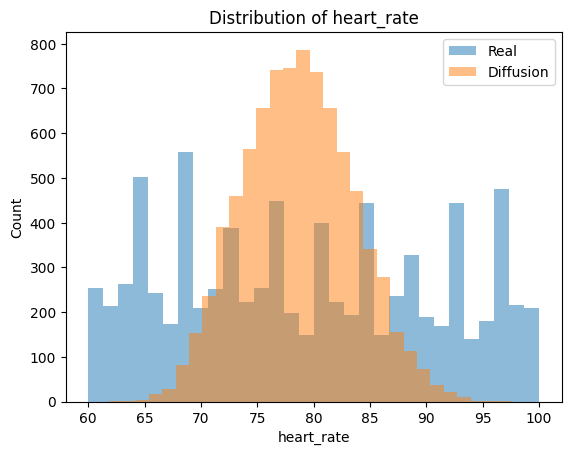

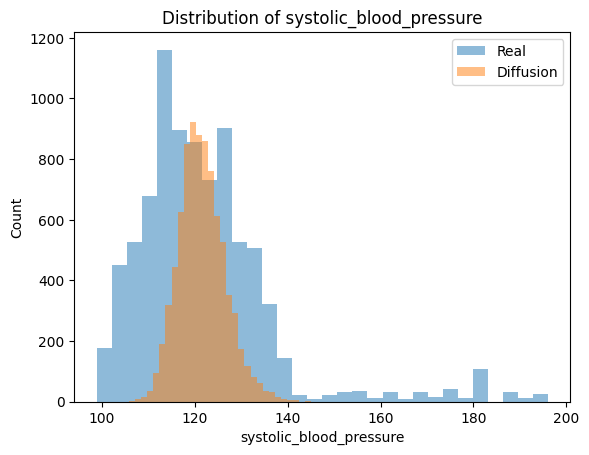

In [ ]:
import matplotlib.pyplot as plt

for col in numerical_cols:
    plt.figure()
    plt.hist(df[col], bins=30, alpha=0.5, label='Real')
    plt.hist(df_diff[col],  bins=30, alpha=0.5, label='Diffusion')
    plt.legend()
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

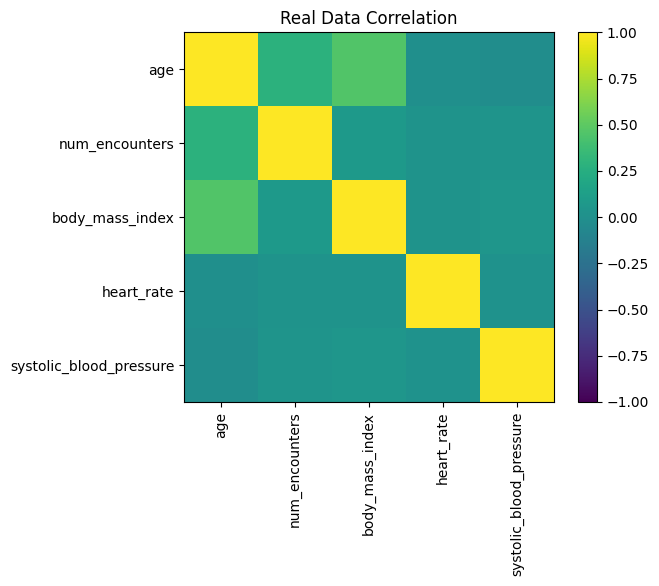

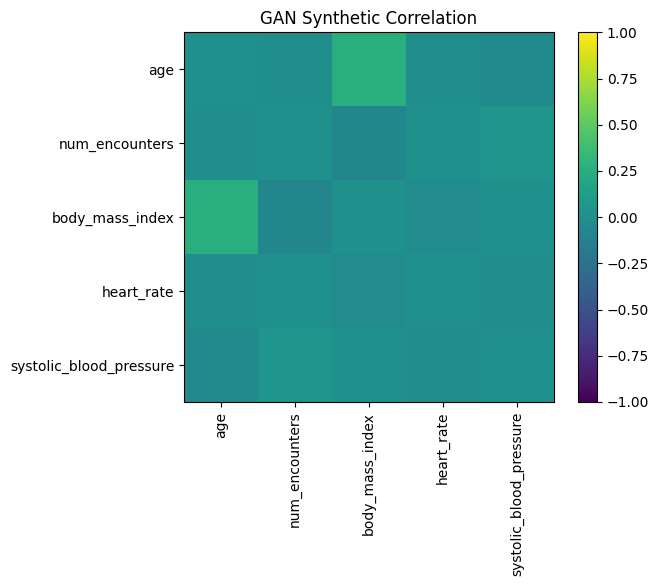

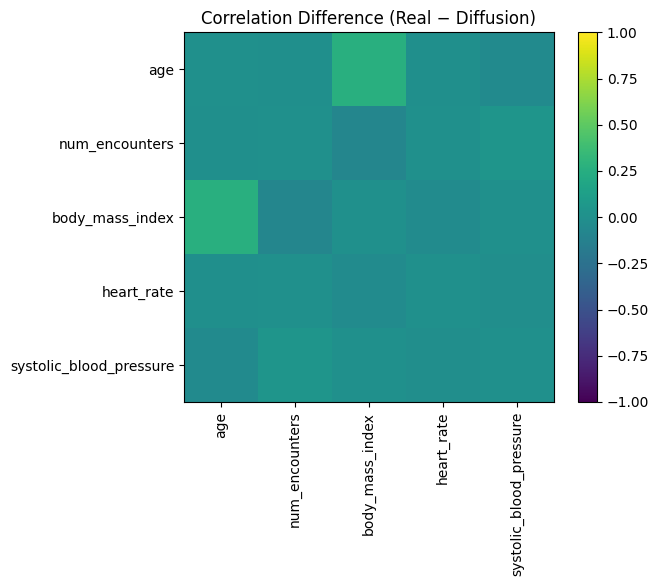

In [ ]:
# compute
corr_real = df[numerical_cols].corr()
corr_diff  = df_diff[numerical_cols].corr()
corr_diff = corr_real - corr_diff

# real
plt.figure()
plt.imshow(corr_real, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('Real Data Correlation')
plt.show()

# VAE
plt.figure()
plt.imshow(corr_diff, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('GAN Synthetic Correlation')
plt.show()

# difference
plt.figure()
plt.imshow(corr_diff, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(numerical_cols)), numerical_cols, rotation=90)
plt.yticks(range(len(numerical_cols)), numerical_cols)
plt.title('Correlation Difference (Real − Diffusion)')
plt.show()

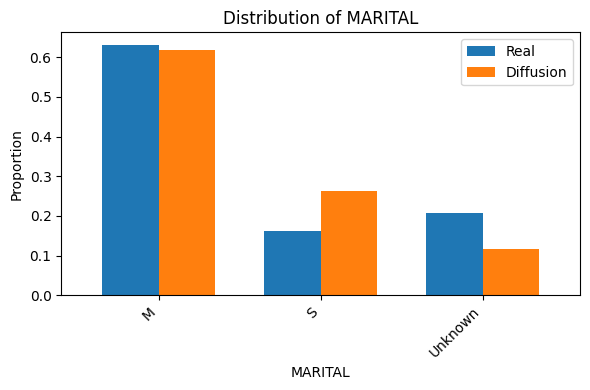

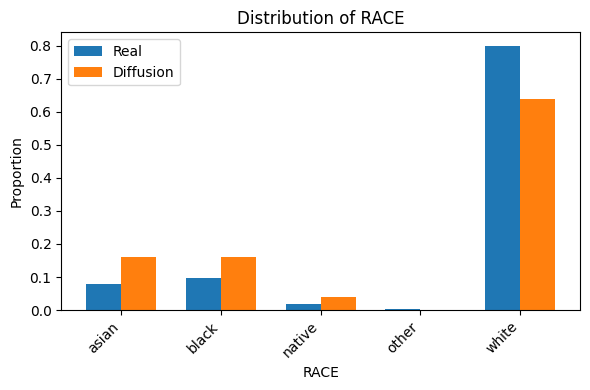

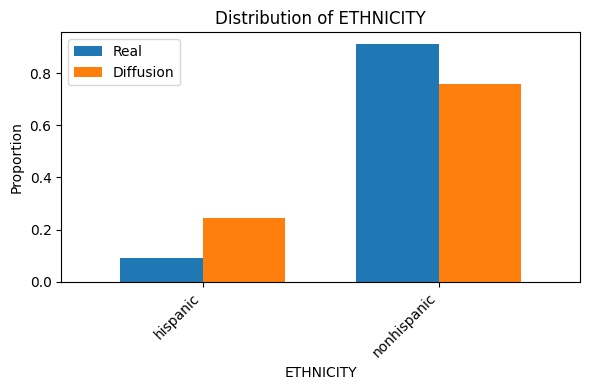

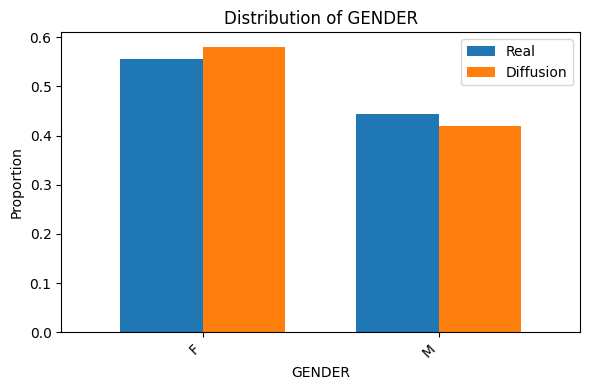

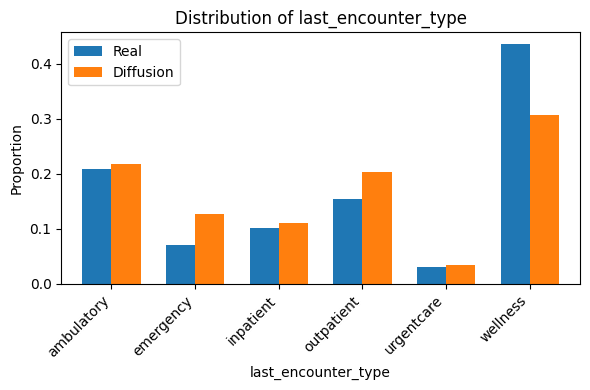

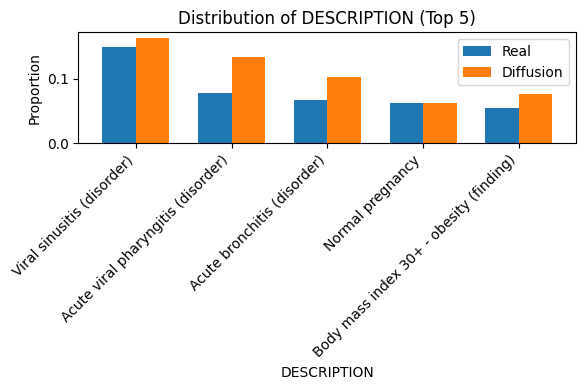

In [ ]:
import matplotlib.pyplot as plt

# List of your categorical columns
cat_cols = ['MARITAL','RACE','ETHNICITY','GENDER','last_encounter_type','DESCRIPTION']

for col in cat_cols:
    if col == 'DESCRIPTION':
        # Get top 5 most frequent categories from real data
        top5 = df[col].value_counts(normalize=True).nlargest(5)
        diff_counts = df_diff[col].value_counts(normalize=True).reindex(top5.index, fill_value=0)
        df_counts = pd.DataFrame({
            'Real': top5,
            'Diffusion':  diff_counts
        })
    else:
      real_counts  = df[col].value_counts(normalize=True).sort_index()
      diff_counts   = df_diff[col].value_counts(normalize=True).reindex(real_counts.index, fill_value=0)

      # Build a DataFrame so matplotlib can auto-align bars
      df_counts = pd.DataFrame({
          'Real': real_counts,
          'Diffusion':  diff_counts
      })

    # Plot grouped bar chart
    ax = df_counts.plot(kind='bar', width=0.7, figsize=(6,4))
    if col == 'DESCRIPTION':
        ax.set_title(f'Distribution of {col} (Top 5)')
    else:
        ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()